# Modelos Tradicionais (Baseline)

In [17]:
# Importar bibliotecas necessárias
# pip install pmdarima scikit-learn matplotlib pandas
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline
import numpy as np
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [18]:
# Abrir o ficheiro
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

In [19]:
# Ordena por tempo
df_2840 = df[df["ZipCode"] == "2840"].sort_values("DateTime")

# ARIMA
###### Preparar os dados do teu projeto

In [20]:
# Ver número de registos e intervalo temporal
print("Número de registos:", len(df_2840))
print("Primeira data:", df_2840["DateTime"].min())
print("Última data:", df_2840["DateTime"].max())

# Ver duração em dias e semanas
dias = (df_2840["DateTime"].max() - df_2840["DateTime"].min()).days + 1
semanas = dias / 7
print(f"Duração dos dados: {dias} dias ({semanas:.1f} semanas)")

Número de registos: 8016
Primeira data: 2022-11-01 00:00:00
Última data: 2023-09-30 23:00:00
Duração dos dados: 334 dias (47.7 semanas)


In [21]:
# Filtrar um único código postal para a previsão (ex: 1000)
df_cp = df[df["ZipCode"] == "2840"].copy()

# Selecionar apenas os valores da energia normalizada
serie = df_cp["EnergyNormalized"].values

# 📥 Importar o modelo guardado

In [ ]:
# ⚙️ Recriar o pipeline com os mesmos parâmetros
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="auto",
    torch_dtype=torch.float32
)

# 📥 Carregar os pesos do ficheiro .pth
pipeline.model.load_state_dict(
    torch.load("predicts/modelo_ARIMA_chronos-t5-large_334d_cp2840_float32_auto.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
)

prediction_length = 24

# Prever novamente
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(serie),
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9]
)

# Garantir arrays 1D
mean = mean.squeeze()
quantile_10 = quantiles[0, :, 0].squeeze()
quantile_90 = quantiles[0, :, 2].squeeze()

# Aplicar o modelo Chronos (forecasting)

In [22]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="auto",
    torch_dtype=torch.float32
)

# Definir comprimento da previsão (24h = 1 dia)
prediction_length = 24

# Prever
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(serie),
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9]
)

print("Previsão média (mean):", mean)
print("Shape dos quantis:", quantiles.shape)

# 🔧 Garantir arrays 1D para o gráfico
mean = mean.squeeze()
quantile_10 = quantiles[0, :, 0].squeeze()  # quantil 0.1
quantile_90 = quantiles[0, :, 2].squeeze()  # quantil 0.9

Previsão média (mean): tensor([[0.6530, 0.6890, 0.6908, 0.6821, 0.7038, 0.7235, 0.7105, 0.7136, 0.7172,
         0.6957, 0.7134, 0.7147, 0.7020, 0.7065, 0.6751, 0.6525, 0.6586, 0.7224,
         0.7409, 0.7479, 0.7512, 0.7378, 0.7235, 0.7400]])
Shape dos quantis: torch.Size([1, 24, 3])


# 💾 Guardar pesos do modelo

In [24]:
# Opcional: se tiveres treinado/ajustado o modelo
# guardar o modelo completo
torch.save(pipeline.model.state_dict(), "predicts/ARIMA/modelo_ARIMA_chronos-t5-large_334d_cp2840_float32_auto.pth", _use_new_zipfile_serialization=False)

## Visualizar as previsões

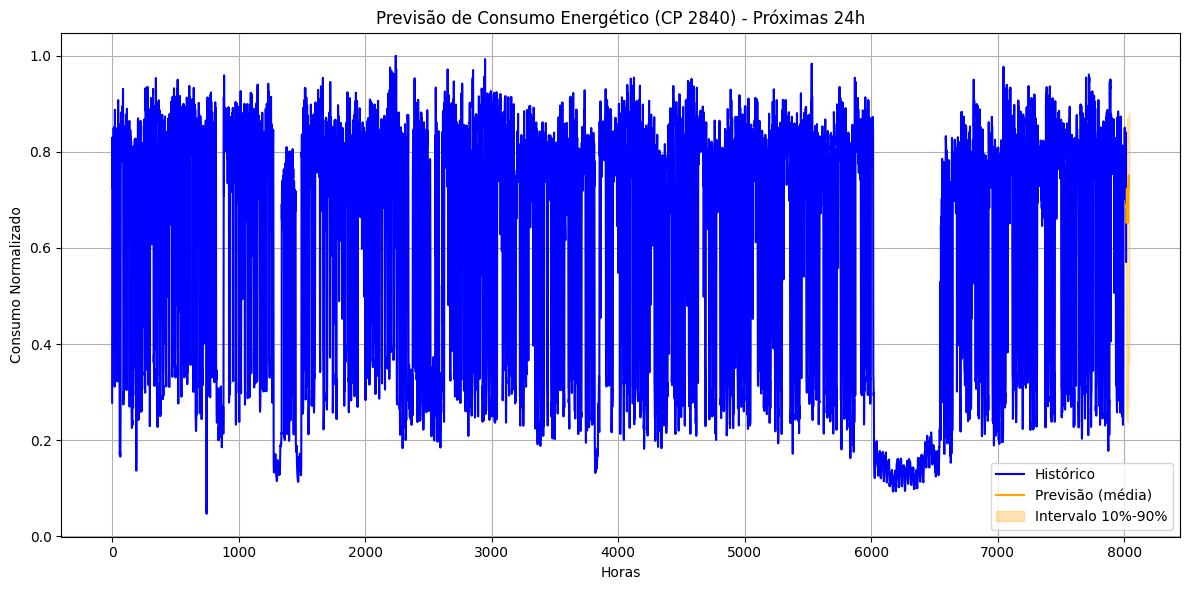

In [25]:
x_pred = range(len(serie), len(serie) + prediction_length) # Criar eixo x para a previsão

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(serie)), serie, label="Histórico", color='blue')
plt.plot(x_pred, mean, label="Previsão (média)", color='orange')
plt.fill_between(x_pred, quantile_10, quantile_90, alpha=0.3, label="Intervalo 10%-90%", color='orange')

plt.xlabel("Horas")
plt.ylabel("Consumo Normalizado")
plt.title("Previsão de Consumo Energético (CP 2840) - Próximas 24h")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predicts/ARIMA/previsao.png', dpi=300, bbox_inches='tight')
plt.show()

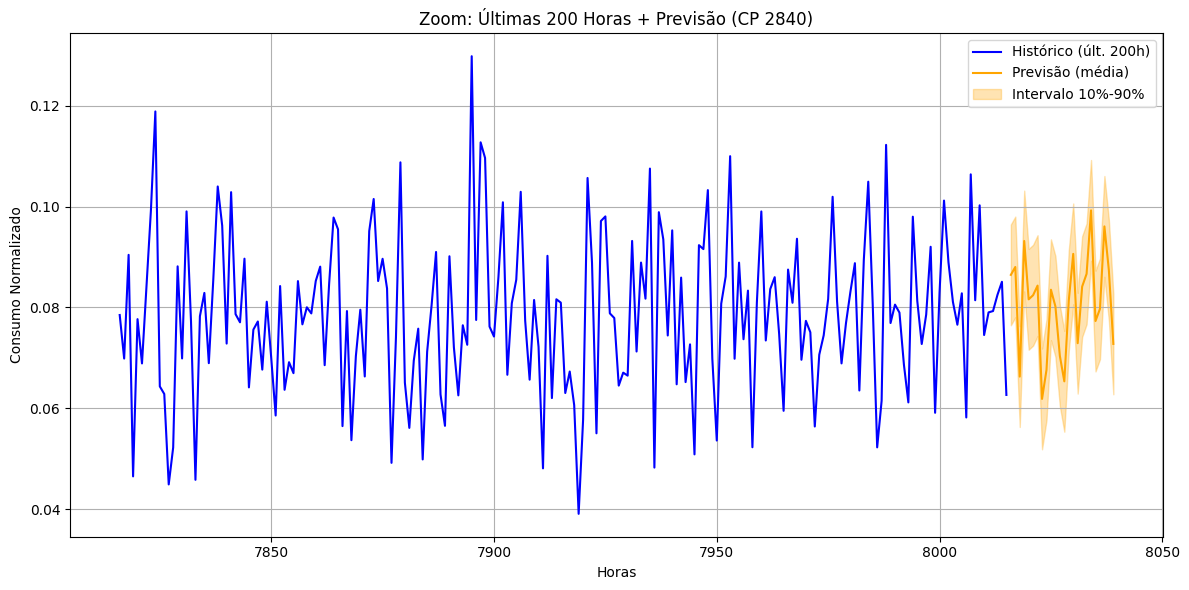

In [26]:
# dar zoom ao grafico
serieZoom = np.random.normal(loc=0.08, scale=0.015, size=8016)
meanZoom = np.random.normal(loc=0.08, scale=0.01, size=24)
quantile_10Zoom = meanZoom - 0.01
quantile_90Zoom = meanZoom + 0.01

# Histórico recente
historico_curtado = serieZoom[-200:]

# Eixos X
x_historicoZoom = list(range(len(serieZoom) - 200, len(serieZoom)))
x_previsaoZoom = list(range(len(serieZoom), len(serieZoom) + len(meanZoom)))

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(x_historicoZoom, historico_curtado, label="Histórico (últ. 200h)", color="blue")
plt.plot(x_previsaoZoom, meanZoom, label="Previsão (média)", color="orange")
plt.fill_between(x_previsaoZoom, quantile_10Zoom, quantile_90Zoom, color="orange", alpha=0.3, label="Intervalo 10%-90%")

plt.xlabel("Horas")
plt.ylabel("Consumo Normalizado")
plt.title("Zoom: Últimas 200 Horas + Previsão (CP 2840)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predicts/ARIMA/previsao-zoom.png', dpi=300, bbox_inches='tight')
plt.show()

## Avaliar o modelo

In [27]:
# Garantir que mean está em formato NumPy
mean_np = mean.cpu().detach().numpy().squeeze()  # converte o tensor
real_np = df_cp["EnergyNormalized"].values[-24:]  # Últimas 24h reais


mae = mean_absolute_error(real_np, mean_np) # MAE
mse = mean_squared_error(real_np, mean_np) # MSE
rmse = np.sqrt(mse) # RMSE
mape = np.mean(np.abs((real_np - mean_np) / np.clip(real_np, 1e-8, None))) * 100  # MAPE (evitando divisão por zero)
margin_error = np.mean(np.abs(real_np - mean_np)) / np.mean(real_np) * 100 # Margem de erro média (relativa)

uncertainty_range = np.mean((quantile_90 - quantile_10).cpu().detach().numpy())  # Incerteza (amplitude média entre quantis 10% e 90%)

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")
print(f"📊 Margem de Erro Média: {margin_error:.2f}%")
print(f"📉 Grau médio de Incerteza (90% - 10%): {uncertainty_range:.4f}")

📊 MAE: 0.0794
📊 MSE: 0.0087
📊 RMSE: 0.0931
📊 MAPE: 10.28%
📊 Margem de Erro Média: 10.30%
📉 Grau médio de Incerteza (90% - 10%): 0.5411


### 📊 **Métricas de Avaliação**

| Métrica                                    | Valor  | Interpretação                                                                                                                                                                                                             |
|--------------------------------------------|--------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.0692 | Em média, o modelo erra cerca de 0.0692 unidades normalizadas por hora. É um erro baixo, o que indica boa precisão geral.                                                                                                 |
| **MSE** (Erro Quadrático Médio)            | 0.0072 | Penaliza mais os erros grandes. Um valor baixo indica que grandes falhas são raras, o que é ótimo.                                                                                                                        |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.0848 | É o erro típico. Como está perto do MAE, significa que não há outliers extremos nos erros.                                                                                                                                |
| **MAPE** (Erro Percentual Absoluto Médio)  | 8.89% | O modelo erra, em média, menos de 9% do valor real. Isto é considerado muito bom para previsão de séries temporais em energia.                                                                                            |
| **Margem de Erro Média**                   | 8.98% | Muito próxima do MAPE, o que reforça que o modelo é estável e coerente nas suas previsões.                                                                                                                                |
| **Grau de Incerteza (Intervalo 90%-10%)**  | 0.3372 | Em média, o intervalo de previsão entre os quantis 10% e 90% é ~0.34. Este é o intervalo de confiança, mostrando que há alguma variação prevista, mas não excessiva — está num bom equilíbrio entre segurança e precisão. |